In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '/kaggle/input/plantdisease/'
width=256
height=256
depth=3

In [16]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [17]:
import os
from os import listdir
import cv2
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import train_test_split


image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error1 : {e}")
image_size = len(image_list)
print(image_size)
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 
# return (x_train, y_train), (x_test,  y_test), n_classes

[INFO] Loading images ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing PlantVillage ...
[INFO] Image loading completed
2952
['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold

In [18]:
image_size = len(image_list)
print(image_size)

2952


In [19]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [20]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [21]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [22]:
from keras.preprocessing.image import ImageDataGenerator

aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

# Model Configuration

In [55]:
from keras import backend as K
from keras.applications.resnet50 import preprocess_input
from keras.layers import (Activation, BatchNormalization, Conv2D, Dense,
                          GlobalAveragePooling2D, GlobalMaxPooling2D,
                          Input, MaxPooling2D, add)
from keras.models import Model
from keras.regularizers import l2
from keras.applications.imagenet_utils import decode_predictions
from keras.utils import get_source_inputs

is_keras_tensor = K.is_keras_tensor

**Required Def**

In [25]:
import warnings

def _obtain_input_shape(input_shape,
                        default_size,
                        min_size,
                        data_format,
                        require_flatten,
                        weights=None):
    if weights != 'imagenet' and input_shape and len(input_shape) == 3:
        if data_format == 'channels_first':
            if input_shape[0] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with {input_shape}'
                    ' input channels.'.format(input_shape=input_shape[0]))
            default_shape = (input_shape[0], default_size, default_size)
        else:
            if input_shape[-1] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with {n_input_channels}'
                    ' input channels.'.format(n_input_channels=input_shape[-1]))
            default_shape = (default_size, default_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_size, default_size)
        else:
            default_shape = (default_size, default_size, 3)
    if weights == 'imagenet' and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting `include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be {default_shape}.'.format(default_shape=default_shape))
        return default_shape
    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[0] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape={input_shape}`'.format(input_shape=input_shape))
                if ((input_shape[1] is not None and input_shape[1] < min_size) or
                    (input_shape[2] is not None and input_shape[2] < min_size)):
                    raise ValueError('Input size must be at least {min_size}x{min_size};'
                                     ' got `input_shape={input_shape}`'.format(min_size=min_size,
                                                                               input_shape=input_shape))
        else:
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[-1] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape={input_shape}`'.format(input_shape=input_shape))
                if ((input_shape[0] is not None and input_shape[0] < min_size) or
                    (input_shape[1] is not None and input_shape[1] < min_size)):
                    raise ValueError('Input size must be at least {min_size}x{min_size};'
                                     ' got `input_shape={input_shape}`'.format(min_size=min_size,
                                                                               input_shape=input_shape))
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None)
            else:
                input_shape = (None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape={input_shape}`'.format(input_shape=input_shape))
    return input_shape


def _tensor_shape(tensor):
    return getattr(tensor, '_keras_shape')

In [56]:
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply, add, Permute, Conv2D
import keras.backend as K

def squeeze_excite_block(input_tensor, ratio=16):
    init = input_tensor
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = _tensor_shape(init)[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x

# Creating Model

In [65]:
from keras.layers.core import Activation, Flatten, Dropout, Dense

def _create_se_net(classes, img_input, depth, width, weight_decay, pooling):

    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    
    init = img_input

    # block 1 (initial conv block)
    x =  Conv2D(32, (3, 3), padding='same', strides=(2, 2))(img_input)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = MaxPooling2D((3, 3))(x)
    x = squeeze_excite_block(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3, 3), padding="same", strides=(1,1))(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    
    x = Conv2D(64, (3, 3), padding="same", strides=(1,1))(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = MaxPooling2D((2, 2))(x)
    x = squeeze_excite_block(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), padding="same", strides=(1,1))(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    
    x = Conv2D(128, (3, 3), padding="same", strides=(1,1))(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=channel_axis)(x)
    x = MaxPooling2D((2, 2))(x)
    x = squeeze_excite_block(x)
    x = Dropout(0.5)(x)
    
    x = Flatten()(x)
#     x = Dense(1024, activation='relu')(x)
#     x = BatchNormalization()(x)
#     x = Dropout(0.5)(x)
    
    x = Dense(classes, activation='softmax')(x)
    

    return x

In [66]:
WEIGHTS_PATH = ""
WEIGHTS_PATH_NO_TOP = ""
def ProposedSENet(input_shape=None, weight_decay=1e-4, weights=None, input_tensor=None, pooling=None,
             classes=1000):

    if weights not in {'imagenet', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')


    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=K.image_data_format(),
                                      require_flatten=False)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    x = _create_se_net(classes, img_input,  depth, width, weight_decay, pooling)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='proposednet')

    # load weights

    return model


In [67]:
inputShape = (height, width, depth)
weights = 'imagenet'
weight_decay = 1e-4

model = ProposedSENet(inputShape, weight_decay, weights, None, None, n_classes)
model.summary()

Model: "proposednet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 128, 128, 32) 896         input_10[0][0]                   
__________________________________________________________________________________________________
activation_31 (Activation)      (None, 128, 128, 32) 0           conv2d_31[0][0]                  
__________________________________________________________________________________________________
batch_normalization_28 (BatchNo (None, 128, 128, 32) 128         activation_31[0][0]              
________________________________________________________________________________________

In [68]:
from keras.optimizers import Adam

opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

[INFO] training network...
Epoch 1/25
73/73 [==============================] - 103s 1s/step - loss: 0.2285 - accuracy: 0.9304 - val_loss: 0.3397 - val_accuracy: 0.9232
Epoch 2/25
73/73 [==============================] - 101s 1s/step - loss: 0.1461 - accuracy: 0.9512 - val_loss: 0.5318 - val_accuracy: 0.8759
Epoch 3/25
73/73 [==============================] - 102s 1s/step - loss: 0.1244 - accuracy: 0.9580 - val_loss: 0.5918 - val_accuracy: 0.8798
Epoch 4/25
73/73 [==============================] - 104s 1s/step - loss: 0.1131 - accuracy: 0.9617 - val_loss: 0.6163 - val_accuracy: 0.8883
Epoch 5/25
73/73 [==============================] - 102s 1s/step - loss: 0.1125 - accuracy: 0.9617 - val_loss: 0.5981 - val_accuracy: 0.8899
Epoch 6/25
73/73 [==============================] - 104s 1s/step - loss: 0.0974 - accuracy: 0.9668 - val_loss: 0.3482 - val_accuracy: 0.9146
Epoch 7/25
73/73 [==============================] - 102s 1s/step - loss: 0.0900 - accuracy: 0.9698 - val_loss: 0.1449 - val_acc

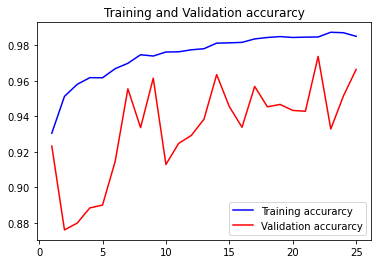

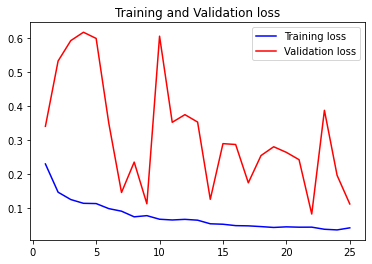

In [69]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [70]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
591/591 [==============================] - 6s 11ms/step
Test Accuracy: 96.63845896720886


In [71]:
print("[INFO] Saving model...")
pickle.dump(model,open('version3.pkl', 'wb'))

[INFO] Saving model...


In [72]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
a = model.predict(x_test)
print(a)
from sklearn import metrics
y_pred = a
matrix = metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print ('Accuracy Score :',accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1)) )
print ('Report : ')
print (classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)) )
# Writing to an excel 
# sheet using Python 
import xlwt 
from xlwt import Workbook 

# Workbook is created 
wb = Workbook() 

# add_sheet is used to create sheet. 
sheet1 = wb.add_sheet('Sheet 1') 


f = open("confusion_matrixV3.txt", "w")
for i in range(len(matrix)):
    for j in range(len(matrix[i])):
        sheet1.write(i, j, str(matrix[i][j]))
        print(matrix[i][j], end=" ")
        f.write(str(matrix[i][j])+" ")
    print("\n")
    f.write("\n")
wb.save('confusion_matrixV3.xls') 

[[5.7932158e-22 2.4672590e-13 9.2216841e-15 ... 7.0515445e-16
  4.2831401e-09 1.7456637e-11]
 [3.1577511e-06 1.3973144e-01 2.7673708e-09 ... 1.0059535e-05
  8.7129740e-07 2.0813129e-09]
 [5.1487881e-05 1.5427849e-10 9.9990320e-01 ... 1.0153974e-06
  1.5439615e-15 1.1052886e-10]
 ...
 [8.9386667e-06 1.3712740e-08 5.3734229e-15 ... 1.5888509e-07
  2.0077551e-12 4.3716482e-14]
 [1.2094242e-03 3.1933308e-02 1.6586155e-05 ... 9.4339821e-06
  4.4459355e-08 3.8955987e-03]
 [5.5630612e-06 3.4319719e-03 2.3362443e-13 ... 1.5285659e-08
  1.7757784e-10 2.3529738e-13]]
Accuracy Score : 0.7411167512690355
Report : 
              precision    recall  f1-score   support

           0       0.86      0.81      0.84        47
           1       0.48      0.93      0.64        30
           2       0.82      0.96      0.88        51
           3       0.91      0.84      0.88        38
           4       0.85      0.88      0.86        25
           5       0.86      0.84      0.85        37
           